###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2018 by D. Koehn, notebook style sheet by L.A. Barba, N.C. Clementi

In [1]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, "r").read())

# 2D axisymmetric spherical SH finite difference modelling  - Earth

After deriving the equations of motion to model 2D axi-symmetric SH wave propgation in the previous lesson, we can now implement the derived staggered grid FD scheme and test it for a simple earth model consisting of a liquid core and homogeneous crust/mantle. A second modelling example incorporates the more realistic 1D PREM.

## Implementation of 2D axisymmetric SH FD scheme

For a staggered FD grid

<img src="images/SG_SH-sph.png" width="50%">

we derived the following 2nd order spatial/temporal staggered grid FD scheme with explicit Leap frog time stepping for the momentum equation:

\begin{align}
\rho(i,j) \frac{v_{\phi}(i,j,n+1/2) - v_{\phi}(i,j,n-1/2)}{dt} &= \partial_r \sigma_{r\varphi} + \frac{1}{r} \partial_\theta \sigma_{\theta\varphi} + \frac{1}{r}(3 \sigma_{r\varphi} + 2\sigma_{\theta\varphi}\; cot \theta) + f_\varphi\notag
\end{align}

using the spatial approximations:

\begin{align}
\partial_r \sigma_{r\varphi} &\approx \frac{\sigma_{r\varphi}(i,j+1/2,n)-\sigma_{r\varphi}(i,j-1/2,n)}{dr}\notag\\
\frac{1}{r} \partial_\theta \sigma_{\theta\varphi} &\approx \frac{1}{r(i,j)}\frac{\sigma_{\theta\varphi}(i+1/2,j,n)-\sigma_{\theta\varphi}(i-1/2,j,n)}{d\theta}\notag\\
\frac{3}{r} \sigma_{r\varphi} & \approx \frac{3}{r(i,j)} \frac{\sigma_{r\varphi}(i,j+1/2,n)+\sigma_{r\varphi}(i,j-1/2,n)}{2}\notag\\
\frac{2}{r} \sigma_{\theta\varphi} cot\; \theta & \approx \frac{2}{r(i,j)}\frac{\sigma_{\theta\varphi}(i+1/2,j,n)+\sigma_{\theta\varphi}(i-1/2,j,n)}{2} cot\; \theta(i,j)\notag\\
f_\varphi &\approx f_\varphi(i,j) \notag
\end{align}

and stress-strain relation:

\begin{align}
\frac{\sigma_{r\varphi}(i,j+1/2,n+1)-\sigma_{r\varphi}(i,j+1/2,n)}{dt} &= \mu \biggl(\partial_r v_\varphi - \frac{1}{r} v_\varphi\biggr) \notag\\
\frac{\sigma_{\theta\varphi}(i+1/2,j,n+1)-\sigma_{\theta\varphi}(i+1/2,j,n)}{dt} &= \mu  \biggl(\frac{1}{r} \partial_\theta v_\varphi - \frac{cot \theta}{r} v_{\varphi} \biggr)\notag\\
\end{align}

with

\begin{align}
\mu \partial_r v_\varphi &\approx \mu_r(i,j+1/2) \frac{v_{\varphi}(i,j+1,n+1/2)-v_{\varphi}(i,j,n+1/2)}{dr}\notag\\
\mu \frac{1}{r} v_\varphi &\approx \mu_r(i,j+1/2) \frac{1}{r(i,j+1/2)} \frac{v_{\varphi}(i,j+1,n+1/2)+v_{\varphi}(i,j,n+1/2)}{2}\notag\\
\mu \frac{1}{r}\partial_\theta v_\varphi &\approx \mu_\theta(i+1/2,j) \frac{1}{r(i+1/2,j)}\frac{v_{\varphi}(i+1,j,n+1/2)-v_{\varphi}(i,j,n+1/2)}{d\theta}\notag\\
\mu \frac{cot\; \theta}{r} v_\varphi &\approx \mu_\theta(i+1/2,j) \frac{cot\; \theta(i+1/2,j)}{r(i+1/2,j)}\frac{v_{\varphi}(i+1,j,n+1/2)+v_{\varphi}(i,j,n+1/2)}{2}\notag
\end{align}

and the harmonically averaged shear moduli:

\begin{align}
\mu_r(i,j+1/2) &= 2 [1/\mu(i,j)+1/\mu(i,j+1)]^{}-1 \notag\\
\mu_\theta(i+1/2,j) &= 2 [1/\mu(i,j)+1/\mu(i+1,j)]^{}-1 \notag\\
\end{align}

In the next step we have to implement the FD code in Python:

In [2]:
# Import Libraries 
# ----------------
import numpy as np
from numba import jit
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
from scipy import interpolate

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

As usual, we first define the modelling parameters for an axisymmetric earth model ...

In [3]:
# Definition of modelling parameters
# ----------------------------------
rcore = 3470 * 1000.0    # earth core radius [m]
rplanet = 6360 * 1000.0  # earth radius      [m]

nr = 200      # number of spatial gridpoints in r-direction
dr = (rplanet - rcore) / nr # spatial gridpoint distance in r-direction

# calculate dtheta based on dr
dtheta = dr / rcore
ntheta = (int) (np.pi / dtheta)  # number of spatial gridpoints in theta-direction
ntheta += 2

# Define PREM model filename
name_model = "PREM_model/PREM.csv"

# Acquisition geometry
tmax = 3000.0           # maximum recording time of the seismogram (s)

isnap = 5  # snapshot interval (timesteps)

Beside a simple earth model consisting of a liquid core and homogeneous crust/mantle, we will also use the 1D **Preliminary Reference Earth Model (PREM)** model to test the FD implementation ...

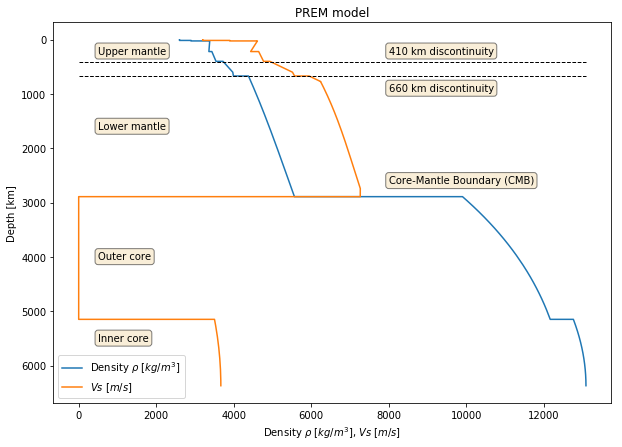

In [4]:
# Read and plot PREM model
# ------------------------
model = np.loadtxt(name_model, delimiter=',', skiprows=0)

radius = model[:,0] * 1000.0 # radius [m]
rho1D = model[:,2] * 1000.0  # density [kg/m^3]
vs1D = model[:,6] * 1000.0   # S-wave velocity model [m/s]

# Define figure size
rcParams['figure.figsize'] = 10, 7

depth = radius[0] - radius

plt.plot(rho1D,depth/1000, label=r"Density $\rho$ [$kg/m^3$]")
plt.plot(vs1D,depth/1000, label=r"$Vs$ [$m/s$]")

# Mark mantle discontinouities
# ----------------------------
x660 = [0,rho1D[-1]]
z660 = [660,660]
z410 = [410,410]

plt.plot(x660,z660,'k--',lw=1)
plt.plot(x660,z410,'k--',lw=1)

# Annotate model
# --------------
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
plt.text(500, 115, "Upper mantle", fontsize=10, verticalalignment='top', bbox=props)
plt.text(8000, 115, "410 km discontinuity", fontsize=10, verticalalignment='top', bbox=props)
plt.text(8000, 800, "660 km discontinuity", fontsize=10, verticalalignment='top', bbox=props)
plt.text(500, 1500, "Lower mantle", fontsize=10, verticalalignment='top', bbox=props)
plt.text(8000, 2500, "Core-Mantle Boundary (CMB)", fontsize=10, verticalalignment='top', bbox=props)
plt.text(500, 3900, "Outer core", fontsize=10, verticalalignment='top', bbox=props)
plt.text(500, 5400, "Inner core", fontsize=10, verticalalignment='top', bbox=props)

plt.title("PREM model")
plt.ylabel("Depth [km]")
plt.xlabel(r"Density $\rho$ [$kg/m^3$], $Vs$ [$m/s$]")
plt.gca().invert_yaxis()
plt.legend()
plt.show()

1D PREM includes a simple crust, lithosphere, astenosphere, the two 410 km andd 660 km discontinuities in the mantle, the liquid outer core and solid inner core. In the SH-case we obviously can only model wave propagation above the liquid outer core, which has the nice side-effect that we don't have to deal with the singularity at the centre of the earth (r=0 km). 

The free-surface and Core-Mantle Boundary (CMB) can be treated with the simple free-surface boundary conditions leading to reflection of the incident wavefields. At the $\theta = 0$ and $\theta = \pi$ boundaries, a symmetry condition is applied, which mirrors the wavefields inside the computation domain to the grid point outside:

\begin{align}
\sigma_{r\phi}(1/2,j) &= \sigma_{r\phi}(3/2,j) \notag\\
\sigma_{r\phi}(n_\theta+1/2,j) &= \sigma_{r\phi}(n_\theta-1/2,j) \notag\\
\sigma_{\theta\phi}(1/2,j) &= - \sigma_{\theta\phi}(3/2,j) \notag\\
\sigma_{\theta\phi}(n_\theta+1/2,j) &= - \sigma_{\theta\phi}(n_\theta-1/2,j) \notag\\
v_\phi(0,j) &= - v_\phi(1,j)\notag\\
v_\phi(n_\theta,j) &= - v_\phi(n_\theta-1,j)\notag
\end{align}

Based on the spatial model discretization defined above, we can calculate the dominant source frequency to satisfy the grid dispersion criterion, assuming $N_\lambda=8$ gridpoints per dominant wavelength and the minimum S-wave velocity in the PREM model

In [5]:
# Calculate dominant frequency of the source wavelet
# --------------------------------------------------
Nlam = 8                     # number of grid points per dominant wavelength
vsmin = vs1D[0]              # minimum S-wave velocity [m/s]
f0 = vsmin / (Nlam * dr)     # centre frequency of the source wavelet [Hz]
print('f0 = ', f0, ' Hz')
print('Period T = ', 1/f0, ' s')
t0   = 4. / f0               # source time shift (s)

f0 =  0.02768166089965398  Hz
Period T =  36.125  s


Time to implement the axisymmetric SH-FD code. We first define the particle velocity $v_\phi$ update ...

In [6]:
# Particle velocity vphi update
# ---------------------------
@jit(nopython=True) # use JIT for C-performance
def update_vel(vphi, srp, stp, dr, dtheta, dt, nr, ntheta, rho, r, theta):
    
    # 2nd order FD operator   
    for i in range(1, ntheta - 1):
        for j in range(1, nr - 1):

            # Calculate spatial derivatives  (2nd order operator)           
            srp_r = (srp[i,j] - srp[i,j-1]) / dr
            stp_t = (stp[i,j] - stp[i-1,j]) / (r[j] * dtheta)            

            # Average stress wavefields at point (i,j)
            vphi_avg = (((srp[i,j] + srp[i,j-1]) / 2) * 3 + 
                         (stp[i,j] + stp[i-1,j]) / np.tan(theta[i])
                       ) / r[j]
            
            # Update particle velocities vphi
            vphi[i,j] = vphi[i,j] + (dt/rho[i,j]) * (srp_r + stp_t + vphi_avg)                               
                
    return vphi

... then update the shear stress components $\sigma_{r\phi}$ and $\sigma_{\theta\phi}$ ...

In [7]:
# Shear stress srp, stp updates
# -----------------------------
@jit(nopython=True) # use JIT for C-performance
def update_stress(vphi, srp, stp, dr, dtheta, dt, nr, ntheta, mur, mutheta, thetah, r, rh):
    
    # 2nd order FD operator
    for i in range(1, ntheta - 1):
        for j in range(1, nr - 1):

            # Calculate spatial derivatives (2nd order operator)
            vphi_r = (vphi[i,j + 1] - vphi[i,j]) / dr
            vphi_theta = (vphi[i + 1,j] - vphi[i,j]) / (dtheta * r[j])

            # calculate vphi at (i,j+1/2)
            vphih = (vphi[i,j + 1] + vphi[i,j]) / (2 * rh[j])
            
            # calculate vphi at (i+1/2,j)
            vphithetah = (vphi[i + 1,j] + vphi[i,j]) / (2 * r[j] * np.tan(thetah[i]))
            
            # Update shear stresses
            srp[i,j] = srp[i,j] + dt * mur[i,j] * (vphi_r - vphih)
            stp[i,j] = stp[i,j] + dt * mutheta[i,j] * (vphi_theta - vphithetah)                    
    
    return srp, stp

... and averaging the shear modulus, where I additionally checked if the shear modulus is not equal 0 to avoid further trouble during the FD modelling ...

In [8]:
# Harmonic averages of shear modulus
# ----------------------------------
@jit(nopython=True) # use JIT for C-performance
def shear_avg(mu, nr, ntheta, mur, mutheta):
    
    for i in range(1, ntheta - 1):
        for j in range(1, nr - 1):
            
            # Calculate harmonic averages of shear moduli                                
            
            # Check if mu=0 on the FD grid
            if(mu[i+1,j]<1e-20 or mu[i,j]<1e-20):
                mutheta[i,j] = 0.0
            else:
                mutheta[i,j] = 2 / (1 / mu[i + 1,j] + 1 / mu[i,j])        
                    
            if(mu[i,j+1]<1e-20 or mu[i,j]<1e-20):
                mur[i,j] = 0.0
            else:
                mur[i,j] = 2 / (1 / mu[i,j + 1] + 1 / mu[i,j])
        
    return mur, mutheta

Finally, we assemble all parts into the 2D SH axisymmetric FD code:

In [9]:
# 2D SH axisymmetric spherical wave propagation (Finite Difference Solution) 
# --------------------------------------------------------------------------
def FD_2D_SH_JIT(dt,dr,dtheta,f0,vs,rho,nr,ntheta,clip,zsrc):        
            
    nt = (int)(tmax/dt) # maximum number of time steps            
    print('nt = ',nt)    

    # Source time function (Gaussian)
    # -------------------------------
    src  = np.zeros(nt + 1)
    time = np.linspace(0 * dt, nt * dt, nt)

    # 1st derivative of a Gaussian
    src  = -2. * (time - t0) * (f0 ** 2) * (np.exp(- (f0 ** 2) * (time - t0) ** 2))
    
    # Initialize coordinates
    # ----------------------
    r    = np.arange(nr)
    r    = rcore + r * dr   # coordinates in r-direction (m)
    rh   = r + (dr/2)       # r-direction coordinates shifted by half a gridpoint (m)

    theta    = np.arange(ntheta)
    theta    = theta * dtheta      # coordinates in theta-direction (rad)
    thetah   = theta + (dtheta/2)  # theta-direction shifted by half a gridpoint (rad)
    
    thetamax = np.max(theta)
    rmax = np.max(r)
    
    #r1, theta1 = np.meshgrid(r, theta) # rectangular plot of polar data
    r1, theta1 = np.meshgrid(r, np.hstack((theta,theta + np.pi)))    
    
    # Define source position    
    isrc =  2   # source location in theta-direction [gridpoints]
    jsrc =  (int)((r[-1] - rcore - zsrc)/dr) # source location in r-direction [gridpoints]    
    
    # Place receivers two grid points below the earth surface
    # and at all grid points in theta direction
    jr = nr - 2            # receiver location in r-direction [gridpoints]
    
    # Initialize empty wavefield arrays
    # ---------------------------------
    vphi    = np.zeros((ntheta,nr))  # particle velocity vphi
    srp     = np.zeros((ntheta,nr))  # shear stress srp
    stp     = np.zeros((ntheta,nr))  # shear stress stp    
    vphi1   = np.vstack((vphi,vphi)) # vphi mirrored at the symmetry axis
    
    # Define S-wave velocity model for visualization
    vs1     = np.vstack((vs,np.flipud(vs)))
    
    # harmonic average of shear moduli
    # --------------------------------
    mu    = np.zeros((ntheta,nr))
    mu    = rho * vs ** 2   # calculate shear modulus
    
    mur       = mu   # initialize harmonic average mur
    mutheta   = mu   # initialize harmonic average mutheta
    mur, mutheta = shear_avg(mu, nr, ntheta, mur, mutheta)
    
    # Initialize empty seismogram
    # ---------------------------
    seis = np.zeros((ntheta,nt))    
    
    # Initalize animation of vy wavefield 
    # -----------------------------------     
    fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
    
    # Plot vphi wavefield
    image1 = ax.pcolormesh(theta1, r1/1000, vphi1, vmin=-clip, vmax=clip, 
                           cmap="RdBu", shading = "flat")
    
    plt.title(r'$V_{\phi}$ wavefield')
    plt.xlabel(r'$\theta$ [rad]')    
           
    plt.ion()    
    plt.show(block=False)
    
    # Time looping
    # ------------
    for it in range(nt):            
            
        # Apply symmetry boundary condition to stress before vel. update
        # --------------------------------------------------------------
        srp[0,:] = srp[1,:]
        srp[-1,:] = srp[-2,:]
        
        stp[0,:] = -stp[1,:]
        stp[-1,:] = -stp[-2,:]        
        
        # Update particle velocity vphi
        # -----------------------------
        vphi = update_vel(vphi, srp, stp, dr, dtheta, dt, nr, ntheta, rho, r, theta)
        
        # Add Source Term at (isrc,jsrc)
        # ------------------------------
        # Absolute particle velocity w.r.t analytical solution
        vphi[isrc,jsrc] = vphi[isrc,jsrc] + (dt * src[it] / (rho[isrc,jsrc] * dr * dtheta))

        # Apply symmetry boundary condition to vphi before stress update
        # --------------------------------------------------------------
        vphi[0,:] = -vphi[1,:]
        vphi[-1,:] = -vphi[-2,:]
        
        # Update shear stress srp, stp
        # ----------------------------
        srp, stp = update_stress(vphi, srp, stp, dr, dtheta, dt, nr, ntheta, mur, mutheta, thetah, r, rh)                        
        
        # Output of Seismogram
        # -----------------
        seis[:,it] = vphi[:,jr]
        
        # display vy snapshots 
        if (it % isnap) == 0:
            vphi1 = np.vstack((vphi,np.flipud(vphi)))
            image1.set_array(vphi1[:-1, :-1].ravel())
            title = '$V_{\phi}$ wavefield, t = ' + str((int)(time[it])) + ' s'
            plt.title(title)
            fig.canvas.draw()
        
    return time, seis

## Homogeneous crust/mantle earth model

We start with the modelling of the wave propagation and seismograms for a homogeneous crust/mantle model with the maximum density/S-wave velocity of the 1D PREM model. The source is placed 30 km below the earth surface. Source wavelet is the first derivative of the Gaussian with a domainant period of 36 s

nt =  2133


<IPython.core.display.Javascript object>


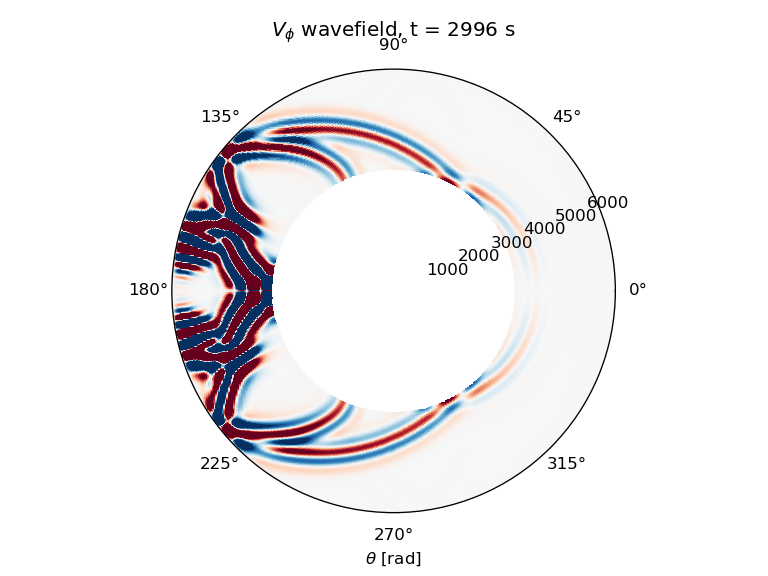

CPU times: user 5min 50s, sys: 2.04 s, total: 5min 52s
Wall time: 1min 31s


In [10]:
# Run SH FD modelling for homogeneous model
# -----------------------------------------
%matplotlib notebook

# define wavefield clip value    
clip = 1e-12

# Define source depth (m)
zsrc = 30.0 * 1000.0

# define homogeneous model
vs0 = np.max(vs1D) * np.ones((ntheta,nr))
rho0 = np.max(rho1D) * np.ones((ntheta,nr))

# calculate time step according to CFL criterion
dt = dr / (np.sqrt(2) * np.max(vs0)) 

%time time, seis_hom = FD_2D_SH_JIT(dt,dr,dtheta,f0,vs0,rho0,nr,ntheta,clip,zsrc)

Let's take a look at the $v_\phi$ seismogram recorded by the geophone at $\theta = 90^o$ placed 30 km below the free-surface

<IPython.core.display.Javascript object>


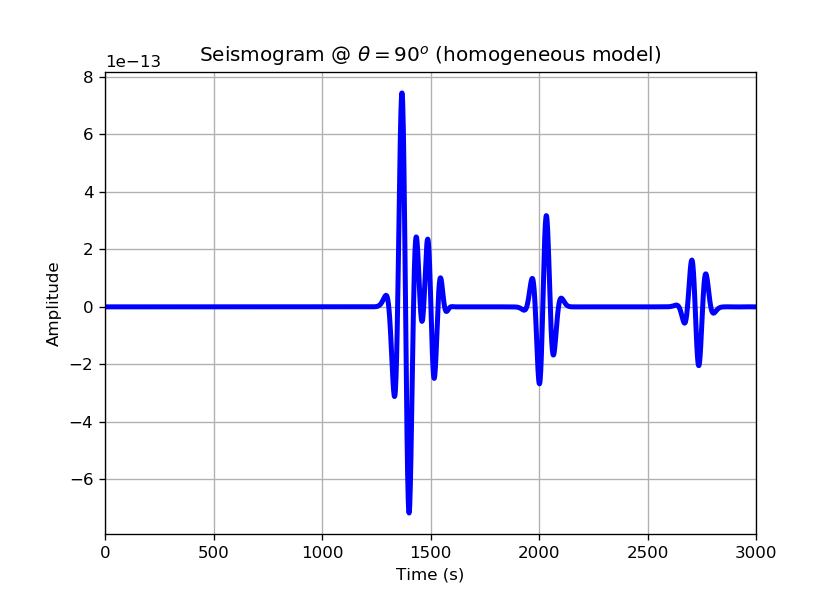

In [11]:
# Plot FD seismogram at polar angle 90°
# -------------------------------------
%matplotlib notebook
# Define figure size
rcParams['figure.figsize'] = 7, 5
plt.plot(time, seis_hom[(int)(ntheta/2),:], 'b-',lw=3,label="FD solution") # plot FD seismogram
plt.xlim(time[0], time[-1])
plt.title(r'Seismogram @ $\theta = 90^o$ (homogeneous model)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

For an easier interpretation of the seismogram, lets plot all seismograms recorded at each grid point in $\theta$-direction:

<IPython.core.display.Javascript object>


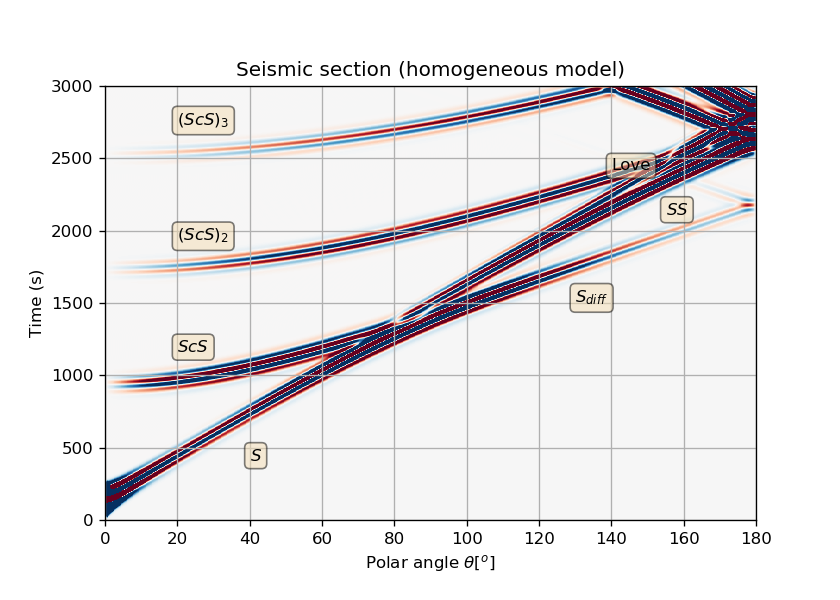

In [12]:
# Plot FD seismograms at polar angles between 0 and 180°
# ------------------------------------------------------
%matplotlib notebook

# Define figure size
rcParams['figure.figsize'] = 7, 5

extent = [0,180.0,tmax,0]
clip = 2e-13
plt.imshow(seis_hom.T, extent=extent, cmap="RdBu",vmin=-clip,vmax=clip, aspect=4e-2)

# annotate major wave phases
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
plt.text(40, 500, r"$S$", fontsize=10, verticalalignment='top', bbox=props)
plt.text(130, 1600, r"$S_{diff}$", fontsize=10, verticalalignment='top', bbox=props)
plt.text(20, 1250, r"$ScS$", fontsize=10, verticalalignment='top', bbox=props)
plt.text(20, 2025, r"$(ScS)_2$", fontsize=10, verticalalignment='top', bbox=props)
plt.text(20, 2825, r"$(ScS)_3$", fontsize=10, verticalalignment='top', bbox=props)
plt.text(155, 2200, r"$SS$", fontsize=10, verticalalignment='top', bbox=props)
plt.text(140, 2500, "Love", fontsize=10, verticalalignment='top', bbox=props)

plt.title(r'Seismic section (homogeneous model)')
plt.xlabel(r'Polar angle $\theta [^o]$')
plt.ylabel('Time (s)')
plt.gca().invert_yaxis()
plt.grid()
plt.show()

The major wave phases are annotated according to the [ISAPEI standard phase list](http://www.isc.ac.uk/standards/phases/). Notice the direct S-wave $S$, diffracted S-wave $S_{diff}$ at the outer core, $SS$ wave free-surface reflections and (multiple) CMB reflections $ScS$, $(ScS)_2$ and $(ScS)_3$. The Love wave generated by the interference of reflected SH body waves from the Core Mantle boundary (CMB) is not as prominent as in the wavefield movie.

## 1D PREM Earth model

Next, we try the 1D PREM model ...

nt =  2133


<IPython.core.display.Javascript object>


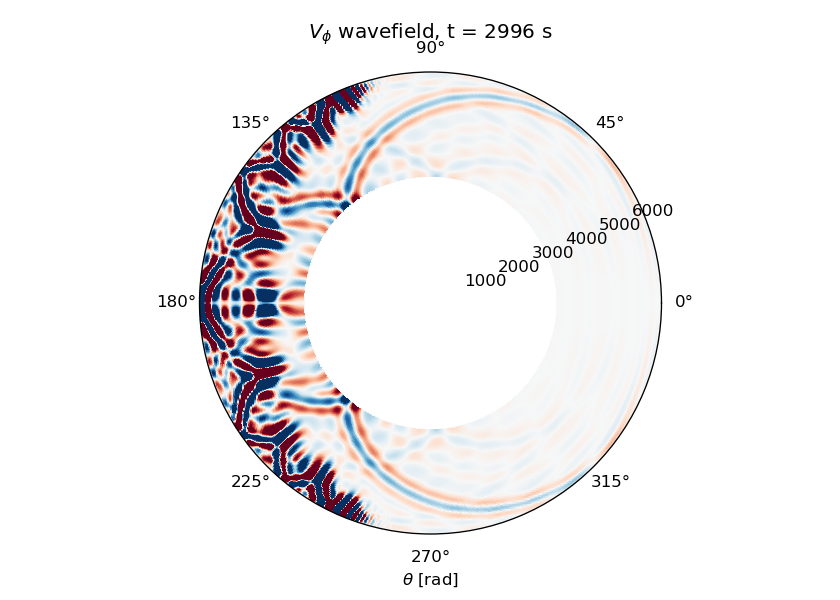

CPU times: user 5min 52s, sys: 2.2 s, total: 5min 54s
Wall time: 1min 33s


In [13]:
# Run SH FD modelling for homogeneous model
# -----------------------------------------
%matplotlib notebook

# Define source depth (m)
zsrc = 30.0 * 1000.0

# Interpolate 1D PREM model on FD grid
r    = np.arange(nr)                    # r-coordinates on FD grid
r    = rcore + r * dr                   # add core radius

# define interpolation function
rshift = 2e4  # shift 1D PREM model with respect to FD model

fvs = interpolate.interp1d(np.flipud(radius-rshift),np.flipud(vs1D))
vs1D_fd = fvs(r)

frho = interpolate.interp1d(np.flipud(radius-rshift),np.flipud(rho1D))
rho1D_fd = frho(r)

# build 2D vs and density PREM models
vs1DPREM = np.tile(vs1D_fd, (ntheta,1))
rho1DPREM = np.tile(rho1D_fd, (ntheta,1))

# define wavefield clip value    
clip = 2e-11

# calculate time step according to CFL criterion
dt = dr / (np.sqrt(2) * np.max(vs1DPREM)) 

%time time_PREM, seis_PREM = FD_2D_SH_JIT(dt,dr,dtheta,f0,vs1DPREM,rho1DPREM,nr,ntheta,clip,zsrc)

Compared to the homogeneous crust/mantle model, the seismic section looks very complex:

<IPython.core.display.Javascript object>


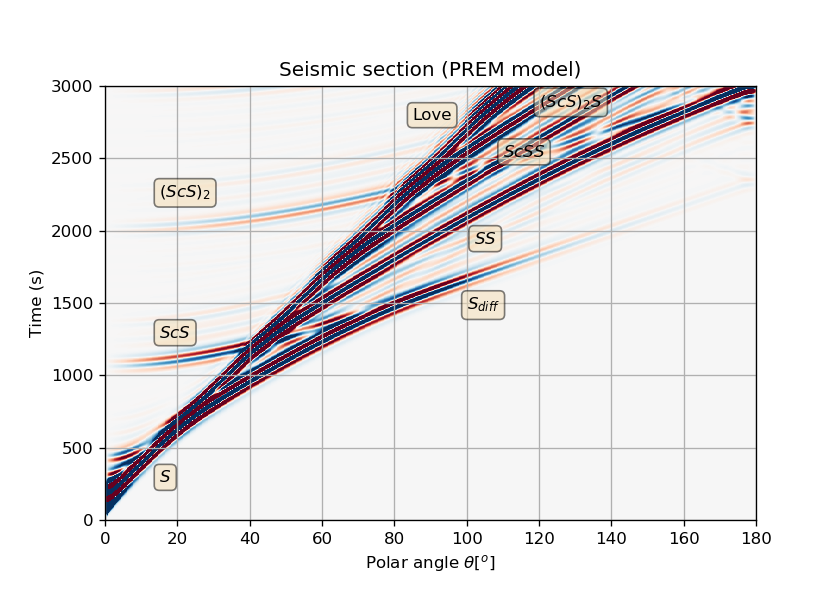

In [14]:
# Plot PREM FD seismograms at polar angles between 0 and 180°
# -----------------------------------------------------------
%matplotlib notebook

# Define figure size
rcParams['figure.figsize'] = 7, 5

extent = [0,180.0,tmax,0]
clip = 2e-11
plt.imshow(seis_PREM.T, extent=extent, cmap="RdBu",vmin=-clip,vmax=clip, aspect=4e-2)

# annotate major wave phases
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
plt.text(15, 350, r"$S$", fontsize=10, verticalalignment='top', bbox=props)
plt.text(100, 1550, r"$S_{diff}$", fontsize=10, verticalalignment='top', bbox=props)
plt.text(15, 1350, r"$ScS$", fontsize=10, verticalalignment='top', bbox=props)
plt.text(15, 2325, r"$(ScS)_2$", fontsize=10, verticalalignment='top', bbox=props)
plt.text(102, 2000, r"$SS$", fontsize=10, verticalalignment='top', bbox=props)
plt.text(110, 2600, r"$ScSS$", fontsize=10, verticalalignment='top', bbox=props)
plt.text(120, 2950, r"$(ScS)_2S$", fontsize=10, verticalalignment='top', bbox=props)
plt.text(85, 2850, "Love", fontsize=10, verticalalignment='top', bbox=props)

plt.title(r'Seismic section (PREM model)')
plt.xlabel(r'Polar angle $\theta [^o]$')
plt.ylabel('Time (s)')
plt.gca().invert_yaxis()
plt.grid()
plt.show()

Like the homogeneous crust/mantle model, the PREM model shows the direct S-wave $S$, diffracted S-wave $S_{diff}$, (multiple) CMB reflections $ScS$, $(ScS)_2$ and free surface reflections $SS$, $ScSS$ and $(ScS)_2S$. Notice also the additional (multiple) reflections from the heterogeneous crust/mantle in the 1D PREM model. The heterogeneous velocity model also leads to a more distinct and dispersive Love wave compared to the homogeneous model.

## What we learned:

* How to implement the 2D axisymmetric SH FD code
* Modelling wave propagation in a simple earth model consisting of a liquid outer core and homogeneous mantle/crust
* Comparison with the modelling results of the 1D PREM model